In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/financial-risk-for-loan-approval/Loan.csv
/kaggle/input/financial-risk-for-loan-approval/CSV Generation.py


In [2]:
# import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# set_options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.2f' %x)

# Problem Breakdown
To develop predictive models for the implied tasks, Regression (RiskScore) and Classification Task (LoanApproved).
1. Risk Score Regression: To predict a continuous risk score associated with each individual's likelihood of loan default or financial instability.
2. Binary Classification: To determine the binary outcome of loan approval, indicating whether an applicant is likely to be approved or denied for a loan.

# Risk Score Regression
For this regression problem, I will be comparing the performance of 3 models:
1. Linear Regression (baseline)
2. Random Forest Regressor
3. LightGBM Regressor


In [4]:
# load dataset
loan_df = pd.read_csv('/kaggle/input/financial-risk-for-loan-approval/Loan.csv')

loan_df.drop(columns=['ApplicationDate'], inplace=True)

loan_df.head()

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,45,39948,617,Employed,Master,22,13152,48,Married,2,Own,183,0.35,1,2,0.36,0,Home,0,29,9,7632,1202,146111,19183,3329.00,0.72,11,126928,0.20,0.23,419.81,0.18,0,49.00
1,38,39709,628,Employed,Associate,15,26045,48,Single,1,Mortgage,496,0.09,5,3,0.33,0,Debt Consolidation,0,21,9,4627,3460,53204,9595,3309.08,0.94,3,43609,0.21,0.20,794.05,0.39,0,52.00
2,47,40724,570,Employed,Bachelor,26,17627,36,Married,2,Rent,902,0.14,2,0,0.24,0,Education,0,20,22,886,895,25176,128874,3393.67,0.87,6,5205,0.22,0.21,666.41,0.46,0,52.00
3,58,69084,545,Employed,High School,34,37898,96,Single,1,Mortgage,755,0.27,2,1,0.44,0,Home,0,27,10,1675,1217,104822,5370,5757.00,0.90,5,99452,0.30,0.30,1047.51,0.31,0,54.00
4,37,103264,594,Employed,Associate,17,9184,36,Married,1,Mortgage,274,0.32,0,0,0.08,0,Debt Consolidation,0,26,27,1555,4981,244305,17286,8605.33,0.94,5,227019,0.20,0.18,330.18,0.07,1,36.00


In [5]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   AnnualIncome                20000 non-null  int64  
 2   CreditScore                 20000 non-null  int64  
 3   EmploymentStatus            20000 non-null  object 
 4   EducationLevel              20000 non-null  object 
 5   Experience                  20000 non-null  int64  
 6   LoanAmount                  20000 non-null  int64  
 7   LoanDuration                20000 non-null  int64  
 8   MaritalStatus               20000 non-null  object 
 9   NumberOfDependents          20000 non-null  int64  
 10  HomeOwnershipStatus         20000 non-null  object 
 11  MonthlyDebtPayments         20000 non-null  int64  
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberOfOpenCreditLines     200

In [6]:
loan_df.describe()

,Age,AnnualIncome,CreditScore,Experience,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
count,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,39.75,59161.47,571.61,17.52,24882.87,54.06,1.52,454.29,0.29,3.02,0.99,0.29,0.05,0.10,23.99,14.96,4946.05,1782.56,96964.40,36252.41,4891.72,0.80,5.00,72294.32,0.24,0.24,911.61,0.40,0.24,50.77
std,11.62,40350.85,51.00,11.32,13427.42,24.66,1.39,240.51,0.16,1.74,0.99,0.16,0.22,0.30,4.95,8.37,6604.89,2245.38,120799.94,47251.51,3296.77,0.12,2.24,117920.02,0.04,0.04,674.58,0.34,0.43,7.78
min,18.00,15000.00,343.00,0.00,3674.00,12.00,0.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,73.00,24.00,2098.00,372.00,1250.00,0.26,0.00,1000.00,0.13,0.11,97.03,0.02,0.00,28.80
25%,32.00,31679.00,540.00,9.00,15575.00,36.00,0.00,286.00,0.16,2.00,0.00,0.16,0.00,0.00,21.00,8.00,1541.75,551.00,31180.25,11196.75,2629.58,0.73,3.00,8734.75,0.21,0.21,493.76,0.18,0.00,46.00
50%,40.00,48566.00,578.00,17.00,21914.50,48.00,1.00,402.00,0.27,3.00,1.00,0.26,0.00,0.00,24.00,15.00,2986.00,1116.00,60699.00,22203.00,4034.75,0.82,5.00,32855.50,0.24,0.24,728.51,0.30,0.00,52.00
75%,48.00,74391.00,609.00,25.00,30835.00,72.00,2.00,564.00,0.39,4.00,2.00,0.39,0.00,0.00,27.00,22.00,5873.25,2126.00,117405.25,43146.50,6163.00,0.89,6.00,88825.50,0.26,0.27,1112.77,0.51,0.00,56.00
max,80.00,485341.00,712.00,61.00,184732.00,120.00,5.00,2919.00,0.92,13.00,7.00,0.90,1.00,1.00,45.00,29.00,200089.00,52572.00,2619627.00,1417302.00,25000.00,1.00,16.00,2603208.00,0.41,0.45,10892.63,4.65,1.00,84.00


In [7]:
# define target and features to create X, y datasets
target = 'RiskScore'
features = [col for col in loan_df.columns if col not in ['RiskScore','LoanApproved']]

# label encoding for training models
categorical_cols = loan_df[features].select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    loan_df[col] = le.fit_transform(loan_df[col].astype(str))

X, y = loan_df[features], loan_df[target]

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

X_train.head()

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio
9153,46,128742,603,0,3,22,24435,24,1,4,3,545,0.37,3,1,0.29,0,0,0,26,4,5710,1566,147723,10061,10728.50,0.80,9,137662,0.20,0.22,1269.04,0.17
14887,26,54252,582,0,1,2,13177,72,2,2,3,368,0.47,1,0,0.36,0,3,0,23,22,1422,1320,86468,5882,4521.00,0.71,4,80586,0.24,0.23,339.24,0.16
2336,46,25727,576,0,1,20,31602,60,1,3,3,511,0.47,2,3,0.71,0,4,0,26,10,8594,247,33662,34410,2143.92,0.89,7,7662,0.25,0.27,970.09,0.69
5886,31,61791,565,0,3,4,14624,36,1,1,3,257,0.28,1,1,0.03,0,1,0,23,29,1515,2902,56641,31147,5149.25,0.86,5,25494,0.22,0.22,558.45,0.16
9692,70,23269,544,2,3,50,12320,36,3,0,3,277,0.35,2,2,0.61,0,1,0,18,5,1997,358,62456,17394,1939.08,0.56,6,45062,0.23,0.24,485.73,0.39


## Linear Regression

### What is Linear Regression?
Linear Regression is the baseline model we'll use in this project for the following reasons:
* Simplicity: it is easy to implement and interpret
* Speed: it trains extremely fast relative to tree-based or deep learning models
* Benchmarking: provides a reference for performance of more advanced models (e.g. LightGBM,Random Forest, Neural Networks)
    * if advanced models don't perform better, it might indicate that the dataset is mostly linear or that more feature engineering is required

In [9]:
# scale features for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train linear regression
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [10]:
# model evaluation
y_pred_lr = lr_model.predict(X_test_scaled)

# RMSE & R2 score as measures of accuracy
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {lr_rmse:.2f}")
print(f"Linear Regression R2 Score: {lr_r2:.2f}")

Linear Regression RMSE: 3.68
Linear Regression R2 Score: 0.77


In [11]:
# coefficients of LR model
lr_coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(lr_coef_df.head(10))

                  Feature      Coefficient
29       BaseInterestRate 1219889502425.13
2             CreditScore  876147159139.29
7            LoanDuration -708171245312.57
6              LoanAmount -457808844401.74
16      BankruptcyHistory             2.97
25          MonthlyIncome            -2.96
15      DebtToIncomeRatio             2.48
18   PreviousLoanDefaults             2.08
28               NetWorth            -1.84
20  LengthOfCreditHistory            -1.43


The coefficients of the Linear Regression model shown above tells us which features push RiskScore up or down according to the magnitudes of the coefficients.

According to the LinearRegression model, BaseInterestRate & CreditScore largely account for a higher RiskScore, while LoanDuration & LoanAmount push RiskScore down.

## Random Forest
### What is Random Forest?
Random Forest is an ensemble learning method based on Decision Trees, which makes predictions by splitting data into branches using thresholds on features.

A Random Forest builds many Decision Trees, each trained on a random subset of the training data (bootstrapping) and a random subset of features.

Predictions are made by averaging all tree outputs for regression.

The randomness of the Random Forest models make the model more robust and better at generalizing (reducing the chances of overfitting, which we tend to observe using Linear Regression).

Linear Regression models struggle if relationships are non-linear, and Random Forest models don't assume linearity (captures non-linear patterns, interactions).

By comparing these two models, we'll be able to deduce if the dataset has more linear or complex non-linear dependencies.

In [12]:
# train random forest regressor
rf = RandomForestRegressor(random_state = 38, n_jobs = -1)

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
}

grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 3,
    scoring = 'r2',
    n_jobs = -1,
    verbose = 1
    )

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

best_rf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestRegressor(max_features='sqrt', n_estimators=1000, n_jobs=-1,
                      random_state=38)

In [13]:
# model evaluation
y_pred_rf = best_rf.predict(X_test)

# RMSE & R2 score as measures of accuracy
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R2 Score: {rf_r2:.2f}")

Random Forest RMSE: 3.07
Random Forest R2 Score: 0.84


**Comparing the Random Forest model to the Linear Regression model**

A quick comparison tells us that the Random Forest (RF) model has a lower RMSE and higher R2 score than the Linear Regression (LR) model, which indicates:
* Lower average prediction error of Risk Score by the RF model than the LR model
* Higher proportion of variance in the target explained by the RF model than the LR model

## LightGBM

### What is LightGBM?
LightGBM stands for Light Gradient Boosting Machine which serves as a "Light"-er version of XGBoost. It is optimized for both speed and memory usage, making it ideal for large-scale data analytics tasks. 

In this project, we are dealing with 33 features and 20,000 observations in a dataset that is structured / tabular. This sets up LightGBM as a compelling choice to handle this heterogeneous large-scale data.

In [14]:
# train LightGBM
lgb_model = lgb.LGBMRegressor(
    objective = 'regression',
    n_estimators = 1000,
    learning_rate = 0.005,
    max_depth = -1,
    num_leaves = 31,
    random_state = 38,
    eval_metric = 'RMSE',
    early_stopping_rounds = 100,
    verbosity = -1,
    n_jobs=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
)

LGBMRegressor(early_stopping_rounds=100, eval_metric='RMSE',
              learning_rate=0.005, n_estimators=1000, n_jobs=-1,
              objective='regression', random_state=38, verbosity=-1)

In [15]:
# model evaluation
y_pred_lgb = lgb_model.predict(X_test)

# RMSE & R2 score as measures of accuracy
lgb_rmse = mean_squared_error(y_test, y_pred_lgb, squared=False)
lgb_r2 = r2_score(y_test, y_pred_lgb)

print(f"LightGBM RMSE: {lgb_rmse:.2f}")
print(f"LightGBM R2 Score: {lgb_r2:.2f}")

LightGBM RMSE: 2.57
LightGBM R2 Score: 0.89


In [16]:
# feature importances of LightBGM model
lgb_impt_df = pd.DataFrame({
    'Feature': lgb_model.feature_name_,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', key=abs, ascending=False)

print(lgb_impt_df.head(10))

                   Feature  Importance
28                NetWorth        3428
20   LengthOfCreditHistory        3127
32  TotalDebtToIncomeRatio        2939
15       DebtToIncomeRatio        2910
30            InterestRate        2593
16       BankruptcyHistory        2105
18    PreviousLoanDefaults        2095
2              CreditScore        1700
25           MonthlyIncome        1657
3         EmploymentStatus        1631


# Loan Approved Binary Classification

For this classification problem, I will be comparing the performance of 3 similar models:
1. Logistic Regression (baseline)
2. Random Forest Classifier
3. LightGBM Classifier

In [17]:
# redefine target and features to create X, y datasets
target = 'LoanApproved'
features = [col for col in loan_df.columns if col not in ['RiskScore','LoanApproved']]

# label encoding for training models
categorical_cols = loan_df[features].select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    loan_df[col] = le.fit_transform(loan_df[col].astype(str))

X, y = loan_df[features], loan_df[target]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

X_train.head()

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio
9153,46,128742,603,0,3,22,24435,24,1,4,3,545,0.37,3,1,0.29,0,0,0,26,4,5710,1566,147723,10061,10728.50,0.80,9,137662,0.20,0.22,1269.04,0.17
14887,26,54252,582,0,1,2,13177,72,2,2,3,368,0.47,1,0,0.36,0,3,0,23,22,1422,1320,86468,5882,4521.00,0.71,4,80586,0.24,0.23,339.24,0.16
2336,46,25727,576,0,1,20,31602,60,1,3,3,511,0.47,2,3,0.71,0,4,0,26,10,8594,247,33662,34410,2143.92,0.89,7,7662,0.25,0.27,970.09,0.69
5886,31,61791,565,0,3,4,14624,36,1,1,3,257,0.28,1,1,0.03,0,1,0,23,29,1515,2902,56641,31147,5149.25,0.86,5,25494,0.22,0.22,558.45,0.16
9692,70,23269,544,2,3,50,12320,36,3,0,3,277,0.35,2,2,0.61,0,1,0,18,5,1997,358,62456,17394,1939.08,0.56,6,45062,0.23,0.24,485.73,0.39


In [18]:
# scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression Classifier

**What is Logistic Regression?**

Logistic Regression is used as the baseline model in this problem for the following reasons:
* Simplicity: uses a single sigmoid function, as opposed to the hundreds of rules in tree-based models
* Fast: computationally cheap for structured data with linear scaling
* Interpretable: each coefficient either increases or decreases LoanApproved probability

Instead of predicting a continuous value (like in Linear Regression), it predicts the probability that an event occurs using the logistic (sigmoid) function for the range [0, 1]:

In [19]:
# train Logistic Regression Classifier
log_clf = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=38)
log_clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=38)

In [20]:
# model predictions
y_pred_log_clf = log_clf.predict(X_test_scaled)
y_prob_log_clf = log_clf.predict_proba(X_test_scaled)[:, 1]

# model evaluation
log_acc = accuracy_score(y_test, y_pred_log_clf)
log_prec = precision_score(y_test, y_pred_log_clf)
log_rec = recall_score(y_test, y_pred_log_clf)
log_f1 = f1_score(y_test, y_pred_log_clf)
log_roc_auc = roc_auc_score(y_test, y_prob_log_clf)

print(f"Accuracy: {log_acc:.3f}")
print(f"Precision: {log_prec:.3f}")
print(f"Recall: {log_rec:.3f}")
print(f"F1 Score: {log_f1:.3f}")
print(f"ROC AUC: {log_roc_auc:.3f}")

Accuracy: 0.947
Precision: 0.906
Recall: 0.876
F1 Score: 0.891
ROC AUC: 0.989


## Random Forest Classifier

In this case, predictions are made by splitting the data based on feature thresholds, e.g.:
* if CreditScore > 650, go to the right node
* if DebtToIncomeRatio < 0.4, then LoanApproved = 1, etc.

At the leaf node (end of the RF), the tree outputs a class label (1 or 0) or a probability distribution (e.g. 75% to be 1, 25% to be 0), where 1 or 0 indicates whether a loan is approved or denied.

In [21]:
# train Random Forest Classifier
# rf_clf = RandomForestClassifier(
#     n_estimators = 1000,
#     max_depth = None,
#     min_samples_split = 2,
#     min_samples_leaf = 1,
#     max_features = 'sqrt',
#     random_state = 38,
#     n_jobs = -1
# )

rf_clf = RandomForestClassifier(random_state=38, n_jobs = -1)

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator = rf_clf,
    param_grid = param_grid,
    cv = 3,
    scoring = 'roc_auc',
    n_jobs = -1,
    verbose = 1
    )

grid_search.fit(X_train, y_train)

best_rf_clf = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [22]:
# model predictions
y_pred_rf_clf = best_rf_clf.predict(X_test)
y_prob_rf_clf = best_rf_clf.predict_proba(X_test)[:, 1]

# model evaluation
rf_acc = accuracy_score(y_test, y_pred_rf_clf)
rf_prec = precision_score(y_test, y_pred_rf_clf)
rf_rec = recall_score(y_test, y_pred_rf_clf)
rf_f1 = f1_score(y_test, y_pred_rf_clf)
rf_roc_auc = roc_auc_score(y_test, y_prob_rf_clf)

print(f"Accuracy: {rf_acc:.3f}")
print(f"Precision: {rf_prec:.3f}")
print(f"Recall: {rf_rec:.3f}")
print(f"F1 Score: {rf_f1:.3f}")
print(f"ROC AUC: {rf_roc_auc:.3f}")

Accuracy: 0.921
Precision: 0.898
Recall: 0.771
F1 Score: 0.830
ROC AUC: 0.977


## LightGBM Classifier

In [23]:
# train LightGBM Classifier
lgb_clf = lgb.LGBMClassifier(
    objective = 'binary',
    n_estimators = 9000,
    learning_rate = 0.005,
    max_depth = 6,
    num_leaves = 236,
    random_state = 38,
    eval_metric = 'accuracy',
    early_stopping_rounds = 100,
    verbosity = -1,
    n_jobs=-1
)

lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
           )

LGBMClassifier(early_stopping_rounds=100, eval_metric='accuracy',
               learning_rate=0.005, max_depth=6, n_estimators=9000, n_jobs=-1,
               num_leaves=236, objective='binary', random_state=38,
               verbosity=-1)

In [24]:
# model predictions
y_pred_lgb_clf = lgb_clf.predict(X_test)
y_prob_lgb_clf = lgb_clf.predict_proba(X_test)[:, 1]

# model evaluation
lgb_acc = accuracy_score(y_test, y_pred_lgb_clf)
lgb_prec = precision_score(y_test, y_pred_lgb_clf)
lgb_rec = recall_score(y_test, y_pred_lgb_clf)
lgb_f1 = f1_score(y_test, y_pred_lgb_clf)
lgb_roc_auc = roc_auc_score(y_test, y_prob_lgb_clf)

print(f"Accuracy: {lgb_acc:.3f}")
print(f"Precision: {lgb_prec:.3f}")
print(f"Recall: {lgb_rec:.3f}")
print(f"F1 Score: {lgb_f1:.3f}")
print(f"ROC AUC: {lgb_roc_auc:.3f}")

Accuracy: 0.949
Precision: 0.915
Recall: 0.873
F1 Score: 0.894
ROC AUC: 0.990


# Overall Results
## RiskScore

Let's compare the performances of the 3 models (Linear Regression, Random Forest Regressor, LightGBM Regressor) and select the model of choice for this regression problem.

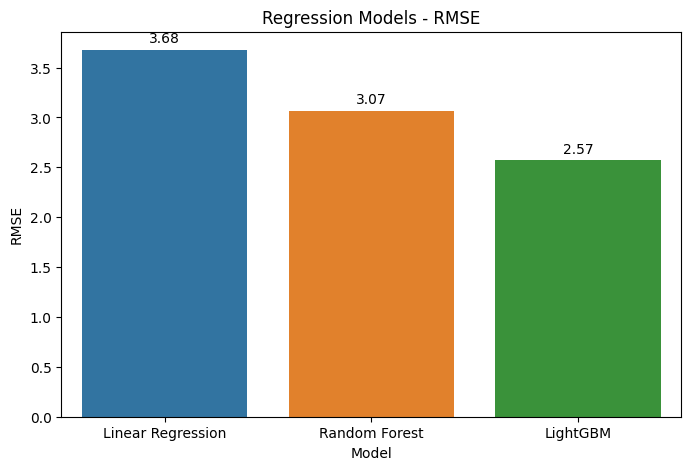

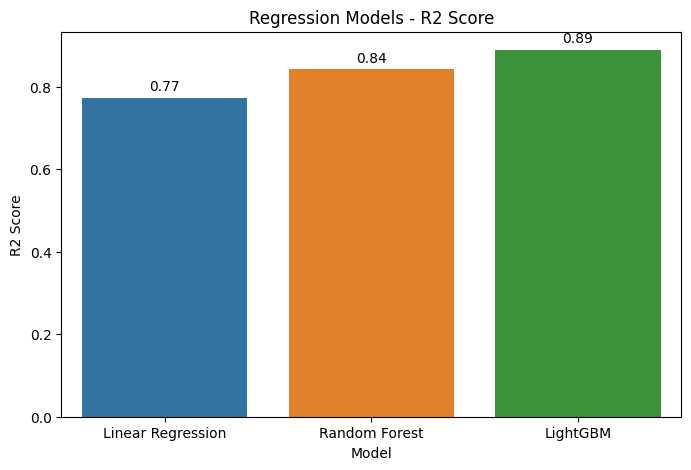

In [25]:
# RMSE & R2 scores of each regression model
reg_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'LightGBM'],
    'RMSE': [lr_rmse, rf_rmse, lgb_rmse],
    'R2': [lr_r2, rf_r2, lgb_r2]
})

# RMSE plot
plt.figure(figsize=(8,5))
ax = sns.barplot(data=reg_df, x='Model', y='RMSE')
plt.title('Regression Models - RMSE')
plt.ylabel('RMSE')
ax.bar_label(ax.containers[0], fmt='%.2f', padding=3)

# R2 plot
plt.figure(figsize=(8,5))
ax2 = sns.barplot(data=reg_df, x='Model', y='R2')
plt.title('Regression Models - R2 Score')
plt.ylabel('R2 Score')
ax2.bar_label(ax2.containers[0], fmt='%.2f', padding=3)


plt.show()

### Interpretation of Results

As we can see from the two bar charts above, LightGBM performs the best of the three models with the lowest RMSE (2.57 vs 3.07 (RF) and 3.68 (LR)), and the highest R2 score (0.89 vs 0.84 (RF) and 0.77 (LR)).

Linear Regression as the baseline model performed reasonably well in prediction RiskScore. However, its inherently linear nature may have limited its ability to capture the nonlinear relationships present in some features.

The Random Forest Regressor model served as an intermediate option, offering greater complexity than the Linear Regression model while still not reaching the full predictive power of LightGBM.

### RMSE

RMSE stands for Root Mean Squared Error. It tells us the average size of prediction errors in the same units as the target (RiskScore).

This means that the LightGBM model predicts RiskScores that are on average 2.57 units away from the actual values. By comparison, LightGBM's predictions are ~30% more accurate than LR in absolute error terms.


### R2

R2 is the coefficient of deteremination which measures how much variance in RiskScore is explained by the model, where a value close to 1 means that the model explains most of the variation.

In this case, LightGBM explains 89% of the variation with an R2 score of 0.89, and captures much more of the underlying relationships in the data as compared to the Random Forest and Linear Regression models.

### Overall Conclusion

Given its superior performance across our performance metrics of choice (RMSE, R2), LightGBM model is the preferred model for predicting RiskScore. Its ability to handle complex, nonlinear relationships makes it the best suited model of the three for this financial risk assessment problem.


## LoanApproved

Now let's compare the performances of the 3 models (Logistic Regression, Random Forest Classifier, LightGBM Classifier) and determine the best model for this classification problem.

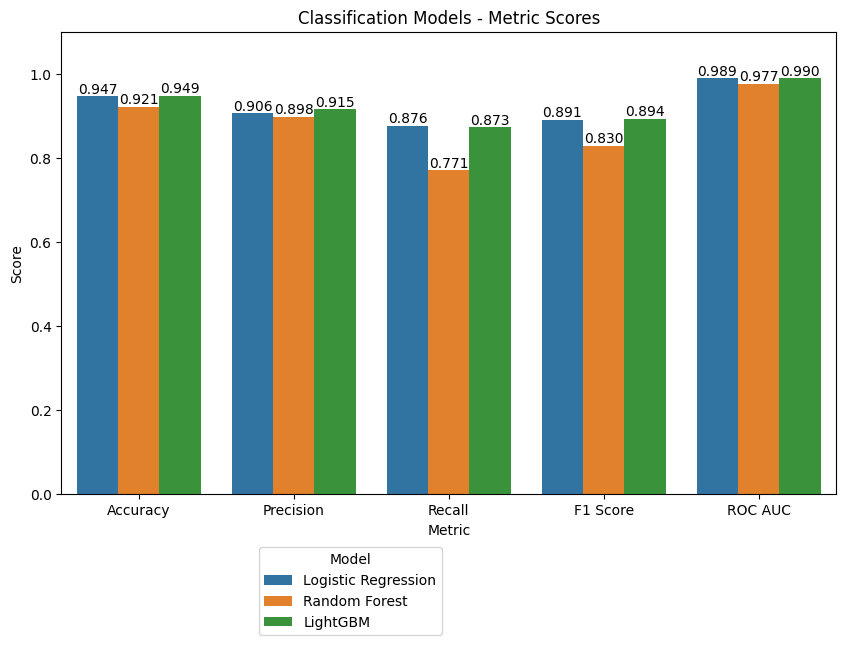

In [26]:
# metric scores of each classification model
clf_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM'],
    'Accuracy': [log_acc, rf_acc, lgb_acc],
    'Precision': [log_prec, rf_prec, lgb_prec],
    'Recall': [log_rec, rf_rec, lgb_rec],
    'F1 Score': [log_f1, rf_f1, lgb_f1],
    'ROC AUC': [log_roc_auc, rf_roc_auc, lgb_roc_auc]
})

# Classifier Scores plot
clf_melted = clf_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=clf_melted, x='Metric', y='Score', hue='Model')
plt.title('Classification Models - Metric Scores')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(0.5, -0.1), title='Model')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

plt.show()

In [27]:
print(clf_df)

                 Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Logistic Regression      0.95       0.91    0.88      0.89     0.99
1        Random Forest      0.92       0.90    0.77      0.83     0.98
2             LightGBM      0.95       0.92    0.87      0.89     0.99


### Interpretation of Results

To start, let's understand the classification metrics used in this performance comparison:
* Accuracy: measures the proportion of total predictions that the model got correct
* Precision: measures the proportion of instances that the model predicted as positive that were actually positive
* Recall: measures the proportion of actual positive instances that the model correctly predicted as positive
* F1 Score: measures the harmonic mean of precision and recall, balancing both metrics
* ROC AUC: measures the model's ability to discriminate between classes, where higher values indicate better separation of approvals vs denials

From the above chart, we can observe a clear trend in performance across all metrics.

Logistic Regression (LogReg), serving as the baseline model, performed well and surprisingly better than the more complex Random Forest (RF) model, producing similar results to the LightGBM (LGBM) Classifier.
The models' performances are listed below:
* LGBM achieved 94.9% accuracy, slightly better than LogReg's 94.7% accuracy, and better than RF's 92.1% accuracy
* LGBM achieved 91.5% precision, slightly better than LogReg's 90.6% and RF's 89.8%
* LGBM achieved 87.3% recall, slightly worse than LogReg's 87.6%, with both outperforming RF's 77.1%
* LGBM achieved 89.4% F1 score, close to LogReg's 89.1%, with both outperforming RF's 83.0%
* LGBM achieved 99.0% ROC AUC score, marginally better than LogReg's 98.9%, with both outperforming RF's 97.7%

**So what do these results mean for our classification problem?**

While LGBM and LogReg are both excellent choices for the prediction of LoanApproved, LogReg would appear to be more effective being a much simpler model than the more advanced and computationally expensive LGBM.

The choice of model would then depend on other considerations such as model interpretability (LogReg) or handling of other complex feature relationships (LGBM).

**Why did Random Forest Classifier not perform as well as LogReg & LightGBM?**

Random Forest Classifier's performance depends on the nature of underlying relationships. The Random Forest is generally able to handle complex nonlinear relationships well, but in the prediction of LoanApproved (whether approve or deny), the decision boundary may be well-approximated by a linear combination of features instead.

Random Forest Classifier also makes decisions by spliting data based on thresholds and averaging the many resulting deep trees. This might have led to a bias toward the majority class, reducing recall on minority cases (which was observed with RF's 77.1% recall). It has to be noted that averaging many deep decision trees makes Random Forests prone to capturing noise or diluting feature importance across splits, especially if features are correlated or not highly predictive, which may have further affected its predictive performance.


## Best Model for this Task

LightGBM outperforms both models for the following reasons:
* Gradient boosting; builds trees sequentially, each correcting errors of the previous, leading to much higher accuracy than bagging (used in Random Forests)
* Ability to capture linear relationships (like Logistic Regression) and complex nonlinear relationships (like Random Forest)
* Uses histogram-based splitting, making training faster and more memory efficient than Random Forests
* Automatically prioritizes the most predictive features without needing extensive preprocessing (for consideration in other tasks with less clean data)
* Produces smoother, better calibrated probability estimates than Random Forest

**Bottom Line**

LightGBM combines the interpretability of linear signals with the flexibility of nonlinear interactions while boosting errors step by step, allowing it to consistently outperform both models across regression and classification tasks.

Take note that the LightGBM parameters can still be tuned further to achieve even better performance, at the cost of more computational time. We can look into a hyperparameter optimization framework such as Optuna to help us search for the best set of parameters.

### Additional Notes

While LightGBM is generally considered one of the strongest gradient boosting methods, there are other models that we could have used, but performance would depend on the data and objectives.

* XGBoost (Extreme Gradient Boosting)
    * Robust regularization sometimes leads to better generalization than LightGBM
    * BUT generally slower than LightGBM on large datasets

* Neural Networks (Deep Learning)
    * Can model very complex nonlinearities and interactions across many features, and find patterns that boosting models miss
    * BUT requires much more tuning, is sensitive to feature scaling, and is much less interpretable

* Ensemble Models (e.g. LogReg + RF + LGBM)
    * Combining multiple models is a common strategy that optimizes performance by leveraging each model's strengths
    * BUT has a more complex pipeline, slower inference, and often much less interpretable